Notation:

Dataloader sur (sur 3)
1. Bon transforms.compose
2. Convertion RGB
3. get_item performant en fonction de l'index reçu

Network (sur 2)
1. Bonne définition du réseau (conv et pool)
2. Forward bien codé pour le flatten
3. Résultat attendu sur 5 epoch: ok

Network (sur 2)
1. Bon appel de Resnet50, avec chargement de poids pré-entrainés
2. Bon changement de la derniere couche
3. Résultat attendu sur 1 epoch : ok

Points bonus avec le réseau ResNet50 entrainé sur 5 epochs (sur 4)
1. Vos impressions générales entre votre réseau et le ResNet. Pourquoi cette différence de score ?
2. Donner une prédiction sur le test set avec l'image associée et les  probabilités normalisées (softmax) 
3. Donner la classe avec la meilleure accuracy sur le test set (bonus)
4. Imprimer le nombre de poids du Resnet et de votre Network

### **Téléchargement et exploration des données**


In [ ]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-320.tgz && tar -xzf imagewoof2-320.tgz

--2020-11-01 17:27:34--  https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-320.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.12.142
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.12.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328288506 (313M) [application/x-tar]
Saving to: ‘imagewoof2-320.tgz’

imagewoof2-320.tgz  100%[===================>] 313.08M  72.4MB/s    in 4.1s    

2020-11-01 17:27:38 (77.1 MB/s) - ‘imagewoof2-320.tgz’ saved [328288506/328288506]



Voici l'arborescence du dossier **imagewoof2-320**
```
imagewoof2-320
├───train
│   ├───n02086240
│   ├───n02087394
│   ├───n02088364
│   ├───n02089973
│   ├───n02093754
│   ├───n02096294
│   ├───n02099601
│   ├───n02105641
│   ├───n02111889
│   └───n02115641
└───val
    ├───n02086240
    ├───n02087394
    ├───n02088364
    ├───n02089973
    ├───n02093754
    ├───n02096294
    ├───n02099601
    ├───n02105641
    ├───n02111889
    └───n02115641



**Combien de samples par split train et valid ? :**

In [ ]:
# There are 9025 train images and 3929 validation images
!find imagewoof2-320/train  -name "*.JPEG" | wc -l && find imagewoof2-320/val  -name "*.JPEG" | wc -l

9025
3929


**Voici le mapping dossier -> label :**


In [ ]:
label_dict = dict(
  n02086240= 'Shih-Tzu',
  n02087394= 'Rhodesian ridgeback',
  n02088364= 'Beagle',
  n02089973= 'English foxhound',
  n02093754= 'Australian terrier',
  n02096294= 'Border terrier',
  n02099601= 'Golden retriever',
  n02105641= 'Old English sheepdog',
  n02111889= 'Samoyed',
  n02115641= 'Dingo'
)

**Plot aléatoire d'un exemple par classe du split "train" (relancez pour avoir d'autres exemples)**

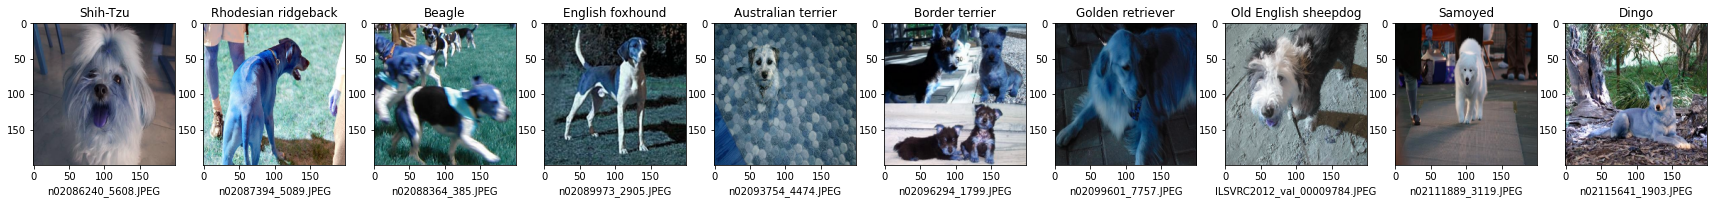

In [ ]:
import random
import matplotlib.pyplot as plt
import cv2
import os
root = os.path.join('imagewoof2-320','train')
plt.figure(figsize=([30, 30]))
for i, (k,v) in enumerate(label_dict.items()):
  plt.subplot(1, 10, i+1)
  random_file=random.choice(os.listdir(os.path.join(root, k)))
  img = cv2.imread(os.path.join(root, k, random_file))
  plt.imshow(cv2.resize(img, (200,200)))
  plt.xlabel(random_file)
  plt.title(v)


### **MODELE PYTORCH**


**Dataloader**

In [ ]:
import glob
import os
import torch
import torch.nn as nn
from PIL import Image
from torchvision.transforms import *
import numpy as np

In [ ]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, split):
        assert split in  ["train", "val"]
        self.image_dir = "imagewoof2-320"

        # Créez un attribut self.images qui contient une liste de toutes les images disponible (leur path) pour le split "split"
        # PS: utilisez la librairie "glob"
        self.images = glob.glob(os.path.join(self.image_dir, split, '*', '*.JPEG'))

        # Attention, notre réseau n'accepte que des images de taille 224x224, il faut les redimensionner 
        # Pour cela, utilisez l'objet transform.Compose
        # https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Compose
        # et stocker le dans l'attribut self.transform
        # Dans le compose, utilisez transform.Resize et transform.toTensor a bon escient
        self.transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
        ])        
        self.labels = list(label_dict.keys())
        
  def __len__(self):
        'Denotes the total number of samples'
        # Que devez vous retourner pour donner la longueur (nombre de samples) du split "split"
        return len(self.images)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Retourne l'image et le label
        
        # L'objet compose que vous avez créé dans le init() prends en entrée une image PIL    
        img_path = self.images[index]
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)

        # Retournez le label. Souvenez vous que le dossier dans le split contient le label
        # Par ex : imagewoof2-320/train/n02111889/ILSVRC2012_val_00032819.JPEG le label est n02111889
        # Il faut bien sur transformer le label en numéro de cluster
        label = img_path.split('/')[-2]
        label = self.labels.index(label)
        label = np.array(label)
        
        return img, label

In [ ]:
train_dataset = Dataset(split="train")
val_dataset = Dataset(split="val")

# Vérifier le bon nombre de samples 
print("Nombre d'images pour train", len(train_dataset))
print("Nombre d'images pour val", len(val_dataset))

training_generator = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_generator = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

Nombre d'images pour train 9025
Nombre d'images pour val 3929


**Network**

In [ ]:
class Network(nn.Module):
    # Vous allez créer un CNN pour classifier les images. Voici une architecture assez courante. Codez la, DANS CET ORDRE, dans self.features:
    # 1ère couche de convolution : 64 filtres, kernel_size de 11, stride de 4, padding de 2 (réfléchissez, ici que vaut in_channels ?)
    # 1ère couche de pooling : kernel_size de 3, stride de 2

    # 2ème couche de convolution : 192 filtres, kernel_size de 5, stride de 1, padding de 2
    # 2ème couche de pooling : kernel_size de 3, stride de 2

    # 3ème couche de convolution : 384 filtres, kernel_size de 3, stride de 1, padding de 1 
    # 4ème couche de convolution : 256 filtres, kernel_size de 3, stride de 1, padding de 1
    # 5ème couche de convolution : 256 filtres, kernel_size de 3, stride de 1, padding de 1

    # 3ème couche de pooling : kernel_size de 3, stride de 2

    def __init__(self, num_classes=None):
        super(Network, self).__init__()
        self.features = nn.Sequential(
            #in_channel de 3 car on gère une image rgb
            nn.Conv2d(3,64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
                         
            nn.Conv2d(64,192,kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
                         
            nn.Conv2d(192,384,kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
    
            nn.Conv2d(256,256,kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        # Ici, si tout va bien, la feature map est de taille 256 x 6 x 6
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 512),
            nn.Linear(512, num_classes),
        )

    def forward(self, x: torch.Tensor):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x= self.classifier(x)
        # Appelez self.features
        # puis aplatissez avec flatten()
        # puis appelez self.classifier
        return x

**Fonction d'entrainement auquel il faut passer "net". On vous la donne déjà codée**

In [ ]:
import torch.optim as optim

def train(net, batch_size=32, learning_rate=1e-4, num_epochs=5):
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    for i in range(num_epochs):
      net.train() # nouveau
      for j, sample in enumerate(training_generator):
        x, y = sample
        optimizer.zero_grad()
        out = net(x.cuda())
        loss = loss_func(out, y.cuda())
        loss.backward()
        optimizer.step()
        print('\r Epoch', i, 'Step', j , ':' , str(loss.data.cpu().numpy()), end="")

      net.eval() # nouveau
      accuracy = []
      for j, sample in enumerate(test_generator):
        x, y = sample
        out = net(x.cuda())
        best = np.argmax(out.data.cpu().numpy(), axis=-1)
        accuracy.extend(list(best == y.data.cpu().numpy()))
      print('\n Accuracy is ' , str(np.mean(accuracy)*100))
    print("done")

In [ ]:
net = Network(10).cuda() # Network à mettre sur cuda
train(net)

 Epoch 0 Step 141 : 1.9636025
 Accuracy is  27.564265716467297
 Epoch 1 Step 141 : 1.6882054
 Accuracy is  23.568337999490964
 Epoch 2 Step 141 : 1.4989835
 Accuracy is  31.229320437770426
 Epoch 3 Step 141 : 0.8492189
 Accuracy is  35.04708577246119
 Epoch 4 Step 141 : 0.6921725

**Sortie attendue (plus ou moins, varie entre 32 et 36)**
```
 Epoch 0 Step 141 : 1.665349
 Accuracy is  21.78671417663528
 Epoch 1 Step 141 : 1.6270891
 Accuracy is  29.727666072792058
 Epoch 2 Step 141 : 2.2747407
 Accuracy is  32.2728429625859
 Epoch 3 Step 141 : 3.3059568
 Accuracy is  31.00025451768898
 Epoch 4 Step 141 : 1.9151628
 Accuracy is  31.509289895647747
done
 ```





**Utilisation de réseaux pré-entrainés**

In [ ]:
import torchvision.models as models

In [ ]:


# Pytorch propose déjà des réseaux CNN péentrainés sur ImageNet (plusieurs millions d'images)
# Allez sur https://pytorch.org/docs/stable/torchvision/models.html pour découvrir les modèles proposés
# ici, appelez un ResNet-50 pré entrainé
net = models.resnet50(pretrained=True, progress=True).cuda()


In [ ]:

# Problème ! ImageNet possède 1000 classes, nous pas... Il faut changer la derniere couche de classification qui s'appelle net.fc
# Redéfinissez la grace a la variable in_features qui contient la taille d'entrée de cette couche

in_features = net.fc.in_features
print(in_features)
net.fc = nn.Linear(in_features, 10).cuda()
train(net, num_epochs=1)

2048
 Epoch 0 Step 141 : 1.9119487
 Accuracy is  91.39730211249682
done


**Sortie attendue Resnet**
```
 Epoch 0 Step 141 : 1.7484074
 Accuracy is  90.65920081445661
done
 ```

In [ ]:
# Vos points bonus ici:Points bonus avec le réseau ResNet50 entrainé sur 5 epochs (sur 4)

# Vos impressions générales entre votre réseau et le ResNet. Pourquoi cette différence de score ?
# Donner une prédiction sur le test set avec l'image associée et les probabilités normalisées (softmax)
# Donner la classe avec la meilleure accuracy sur le test set (bonus)
# Imprimer le nombre de poids du Resnet et de votre Network




# Pour le bonus 2, choisissez un exemple aléatoirement 
# PS : pour normaliser les sorties de votre réseau en probabilité, utilisez softmax
# https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.softmax
